In [ ]:
# connect to google colab
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Sentence Segmentation
Extract noun, noun phrase, verb, verb phrase

In [ ]:
%matplotlib inline
### INSTALL GHOSTSCRIPT (Required to display NLTK trees) ###
!apt install ghostscript python3-tk

### CREATE VIRTUAL DISPLAY ###
!apt-get install -y xvfb # Install X Virtual Frame Buffer
import os
os.system('Xvfb :1 -screen 0 1600x1200x16  &')    # create virtual display with size 1600x1200 and 16 bit color. Color can be changed to 24 or 8
os.environ['DISPLAY']=':1.0'    # tell X clients to use our virtual DISPLAY :1.0.


Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-tk is already the newest version (3.6.9-1~18.04).
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono gsfonts libcupsfilters1 libcupsimage2
  libgs9 libgs9-common libijs-0.35 libjbig2dec0 poppler-data
Suggested packages:
  fonts-noto ghostscript-x poppler-utils fonts-japanese-mincho
  | fonts-ipafont-mincho fonts-japanese-gothic | fonts-ipafont-gothic
  fonts-arphic-ukai fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts libcupsfilters1
  libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0 poppler-data
0 upgraded, 11 newly installed, 0 to remove and 31 not upgraded.
Need to get 14.1 MB of archives.
After this operation, 49.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 fonts-droid-fallback all 1:6.0.

In [ ]:
import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords   
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

from bs4 import BeautifulSoup 
from IPython.display import display
lemmatizer = nltk.WordNetLemmatizer()
from tqdm import tqdm
import re 

import pandas as pd
import numpy as np

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# COLAB CONFIG
# change colab flag to false if train using jupyter notebook
COLAB_FLAG = True
COLAB_FILEPATH = './drive/My Drive/4034-amazon-review-classification/' if COLAB_FLAG == True else './'
pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline

In [ ]:
# read the crawled data
data_ = pd.read_csv(COLAB_FILEPATH+'data/trip-advisor-comments.csv')
print(f'Shape of the dataset:{data_.shape}')
data_.head()

Shape of the dataset:(97190, 5)


,Restaurant Name,Restaurant Type,Reviewer's Name,Rating,Comment
0,Positano @ RP,"Italian, European",aisvslife98,5,I enjoyed my time here with my girlfriends! Fa...
1,Positano @ RP,"Italian, European",Odyssey44198198885,5,Wonderful and amazing service experience. Defi...
2,Positano @ RP,"Italian, European",Ninifazelin,5,Great food and wonderful service! Will definit...
3,Positano @ RP,"Italian, European",Amaliamazlan,5,Not my first time in Positano and definitely w...
4,Positano @ RP,"Italian, European",Shahzanstim,5,Excellent service from the staff. The beef was...


### Filtering of the test data

In [ ]:
# remove duplication of entries
data=data_.drop_duplicates(subset={"Reviewer\'s Name","Comment"}, 
                                             keep='first', inplace=False)
print(f'Shape of the dataset:{data.shape}')

Shape of the dataset:(88042, 5)


In [ ]:
data_comment_ = data['Comment']
data_comment = data_comment_.to_frame()
print(data_comment.shape)
data_comment.head()

(88042, 1)


,Comment
0,I enjoyed my time here with my girlfriends! Fa...
1,Wonderful and amazing service experience. Defi...
2,Great food and wonderful service! Will definit...
3,Not my first time in Positano and definitely w...
4,Excellent service from the staff. The beef was...


In [ ]:
list(data_comment_)

["I enjoyed my time here with my girlfriends! Fajar, our server, gave recommendations for food and drinks which were fantastic and check up on our meals twice. Ordered a dessert to celebrate two of my girlfriend's birthdays, and exceeding my expectations came with another complimentary dessert!  Second time here, and service is great as usual! Thank you",
 'Wonderful and amazing service experience. Definitely will return for dining again next time in the future.',
 'Great food and wonderful service! Will definitely return. The calzone is recommended. Friendly and attentive staff. Good variety of food',
 "Not my first time in Positano and definitely won't be my last. Such amazing service and such delicious food. Despite the restaurant being full, food will always be nice. I will be back soon! Can't wait to see the upgrade!",
 'Excellent service from the staff. The beef was so tender and the risotto was nice! Would definitely recommend it!',
 'Place has great food, great ambience and the

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                  "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                  "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                  "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                  "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                  "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                  "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                  "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                  "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                  "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                  "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                  "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                  "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                  "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                  "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                  "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                  "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                  "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                  "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                  "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                  "you're": "you are", "you've": "you have"}

In [ ]:
# remove the stop-words and store cleaned data in a separate file
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        #removing short word
        if len(i)>=3:                  
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [ ]:
data_comment_list = []
for t in tqdm(data_comment['Comment']):
    data_comment_list.append(text_cleaner(t))

100%|██████████| 88042/88042 [00:23<00:00, 3702.00it/s]


In [ ]:
data_comment_list[:5]

['enjoyed time girlfriends fajar server gave recommendations food drinks fantastic check meals twice ordered dessert celebrate two girlfriend birthdays exceeding expectations came another complimentary dessert second time service great usual thank',
 'wonderful amazing service experience definitely return dining next time future',
 'great food wonderful service definitely return calzone recommended friendly attentive staff good variety food',
 'first time positano definitely last amazing service delicious food despite restaurant full food always nice back soon cannot wait see upgrade',
 'excellent service staff beef tender risotto nice would definitely recommend']

In [ ]:
tokens_list = []
start = 0
for i in range(1000):
    tokens_list.append([nltk.word_tokenize(sent) for sent in [data_comment_list[i]]])
    #print(tokens_list[start][0])
    start+=1

# POS Tagging of the dataframe

In [ ]:
postag_list = []
# pos tagging the data in a list of tokens
for i in range(len(tokens_list)):
    postag_list.append([nltk.pos_tag(sent) for sent in tokens_list[i]][0])
#postag_list

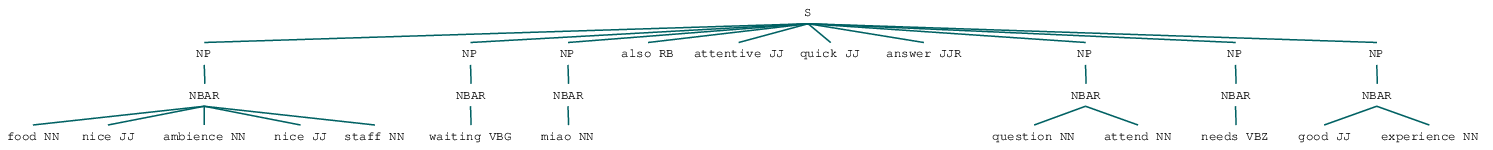

In [ ]:
# Look at the parse tree
tree_list = []
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        {<RB.?>*<VB.?>*<JJ>*<VB.?>+<VB>?} # Verbs and Verb Phrases
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
        
"""

cp = nltk.RegexpParser(grammar)
for i in range(len(tokens_list)):
    tree_list.append(cp.parse(postag_list[i]))
    #print(display(tree))

# print and visualise all the trees 
#for j in range(len(tree_list)):
 #   print(display(tree_list[i]))

# display an example of a parse tree
tree_list[100]

In [ ]:
def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label() =='NP'):
        yield subtree.leaves()
        
def get_word_postag(word):
    if pos_tag([word])[0][1].startswith('J'):
        return wordnet.ADJ
    if pos_tag([word])[0][1].startswith('V'):
        return wordnet.VERB
    if pos_tag([word])[0][1].startswith('N'):
        return wordnet.NOUN
    else:
        return wordnet.NOUN
    
def normalise(word):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    postag = get_word_postag(word)
    word = lemmatizer.lemmatize(word,postag)
    return word

def get_terms(tree):    
    for leaf in leaves(tree):
        terms = [normalise(w) for w,t in leaf]
        yield terms

In [ ]:
feature_list = []
for i in range(len(postag_list)):
    features = []
    terms = get_terms(tree_list[i])
    for term in terms:
        _term = ''
        for word in term:
            _term += ' ' + word
        features.append(_term.strip())
    feature_list.append(features)

In [ ]:
feature_list[5:10]

[['place great food great ambience staff',
  'friendly shout',
  'naufal pleasant service'],
 ['place chill business enviroment naufal complete bdae food awesome cleaniess ambience superb'],
 ['love',
  'risotto third time',
  'come',
  'highly recommend',
  'love risotto truffle mushroom risotto',
  'try'],
 ['food service ambience everything', 'try', 'pizza'],
 ['great food love pasta milk',
  'shake',
  'staff attentive prompt truffle fry',
  'seafood',
  'linguine roche milk shake',
  'recommend']]

In [ ]:
feature_list[11]

['food', 'delicious worth', 'penny', 'definitely recommend', 'friend family']